In [32]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [33]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [34]:
import os
import cv2
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K

In [35]:
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
from sklearn.cross_validation import train_test_split
import math
import glob
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


In [36]:
ff = glob.glob(r"C:\Users\pruthvi\Desktop\009Longitudinal_prediction\Example_MRI_Data\*")

ff[0]
len(ff)
images = []
for f in range(len(ff)):
    a = nib.load(ff[f])
    a = a.get_data()
    a = a[:,78:129,:]
    for i in range(a.shape[1]):
        images.append((a[:,i,:]))
print (a.shape)

(256, 51, 320)


In [37]:
a[:,0,:].shape
images = np.asarray(images)
images.shape
images = images.reshape(-1, 256,320,1)
images.shape
m = np.max(images)
mi = np.min(images)

m, mi
images = (images - mi) / (m - mi)

np.min(images), np.max(images)
#temp = np.zeros([306,259,323,1])
#temp[:,3:,3:,:] = images

#images=temp

train_X,valid_X,train_ground,valid_ground = train_test_split(images,images,test_size=0.2,random_state=13)

# Shapes of training set
print("Dataset (images) shape: {shape}".format(shape=images.shape))

Dataset (images) shape: (306, 256, 320, 1)


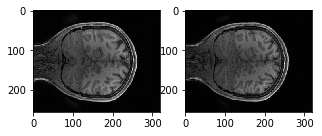

In [38]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_X[0], (256,320))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(valid_X[0], (256,320))
plt.imshow(curr_img, cmap='gray')

In [44]:
batch_size = 5
epochs = 50
inChannel = 1
x, y = 256, 320
input_img = Input(shape = (x, y, inChannel))


In [45]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [46]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())


In [47]:
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256, 320, 1)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 256, 320, 32)      320       
_________________________________________________________________
batch_normalization_31 (Batc (None, 256, 320, 32)      128       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 256, 320, 32)      9248      
_________________________________________________________________
batch_normalization_32 (Batc (None, 256, 320, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 128, 160, 32)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 128, 160, 64)      18496     
__________

In [48]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Train on 244 samples, validate on 62 samples
Epoch 1/50
244/244 [==============================] - 5s 22ms/step - loss: 0.0610 - val_loss: 0.1065
Epoch 2/50
244/244 [==============================] - 4s 16ms/step - loss: 0.0172 - val_loss: 0.2153
Epoch 3/50
244/244 [==============================] - 4s 16ms/step - loss: 0.0110 - val_loss: 0.0437
Epoch 4/50
244/244 [==============================] - 4s 15ms/step - loss: 0.0093 - val_loss: 0.0805
Epoch 5/50
244/244 [==============================] - 4s 15ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 6/50
244/244 [==============================] - 4s 16ms/step - loss: 0.0037 - val_loss: 0.0206
Epoch 7/50
244/244 [==============================] - 4s 16ms/step - loss: 0.0029 - val_loss: 0.0071
Epoch 8/50
244/244 [==============================] - 4s 15ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 9/50
244/244 [==============================] - 4s 15ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 10/50
244/244 [=========================

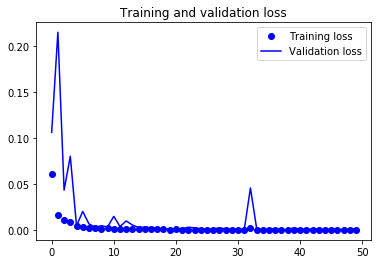

In [49]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [50]:
autoencoder = autoencoder.save_weights('autoencoder_mri.h5')
